# Building a Robot Judge - Problem Set 1 - Solution Raphael Husistein

In [1]:
import pickle
import string
import os
import re
import random
from collections import Counter
from itertools import islice
import spacy
import nltk
import pandas as pd
import numpy as np
from linearmodels.iv import IV2SLS
from keras.models import Sequential
from keras.regularizers import l2
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from wordcloud import WordCloud
from matplotlib import pyplot
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.calibration import calibration_curve
from gensim.models.ldamodel import LdaModel
from gensim import corpora

Using TensorFlow backend.
C:\Users\test\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## General functions that are used across solutions (possibly for later reuse)
This functions will be used across the different problem sets for easy data processing.

In [28]:
def get_all_case_filenames():
    """Return a list of all filenames in the cases directory"""
    cases = []
    for root, dirs, files in os.walk("./cases/", topdown=False):
        for name in files:
            cases.append(os.path.join(root, name))
    return cases

def get_cleaned_string_from_file(filename):
    """Return the content of a file as a string with the first line removed and newlines striped"""
    with open(filename, "r", encoding="utf-8") as file:
        # skip the first line with the name of the judge
        content = ""
        for line in islice(file, 1, None):
            content += line.strip()
    return content

def get_spacy_doc(nlp, string):
    """Load a string into a spacy document"""
    return nlp(string)

def get_sentences(nlp, doc):
    """Return all sentences of a spacy doc"""
    return [sent.string.strip() for sent in doc.sents]

def get_words(nlp, doc):
    """Return all tokens except punctuation from a spacy document (=words)"""
    return [token.text for token in doc if not token.is_punct and not token.is_currency and not token.like_num]

def get_year_from_filename(filename):
    """Return the year extracted from the filename"""
    return re.search("\d{4}", filename).group(0)

def get_case_name_from_filename(filename):
    """Return the case name extracted from the filename"""
    return re.search("(?<=\d{4}\_).*(?=\.)", filename).group(0)

def generate_ngram(word_list, n, ending_noun=False):
    """Return a list of ngrams (all words lowercase)"""
    ngrams = []
    return [" ".join([gram.lower_ for gram in ngram]) for ngram in zip(*[word_list[i:] for i in range(n)]) if not ending_noun or ngram[2].pos_ == "NOUN"]

def normalize_text(doc):
    """
    Return cleaned list of tokens
    Removes: punctuation, numbers, spaces, stop words, and drops non alphabetic chars 
    """
    tokens = [token for token in doc if not token.is_punct | token.is_space | token.like_num | token.is_stop and token.is_alpha]
    return tokens

def get_reversed_dict(filename):
    """Return dict with the case name as the key and 0/1 for overruled"""
    with open(filename, "r", encoding="utf-8") as reversed_file:
        decisions = {}
        for line in islice(reversed_file, 1, None):
            case = line.split(",")
            decisions[case[0].strip()] = int(case[1].strip())
    return decisions

def get_sentiment_score(analyser, sentence):
    """Return the sentiment score of a sentence calculated with VADER from NLTK library"""
    return analyser.polarity_scores(sentence)

def load_pickled_object(filename):
    """Loads a pickled python object from a file"""
    with open(filename, "rb") as model:
        return pickle.load(model)

def custom_pipeline(nlp):
    """Return custom spacy pipeline"""
    return (nlp.parser) 

def clean_document(doc):
    """Clean document as described in the lecture"""
    stemmer = SnowballStemmer("english")
    stop = set(stopwords.words("english"))
    translator = str.maketrans("","",string.punctuation) 
    doc = doc.translate(translator)
    doc = [i for i in doc.lower().split() if i not in stop and len(i) < 10]
    doc = [stemmer.stem(t) for t in doc]
    return doc

def color_func(word=None, font_size=None, position=None, orientation=None, random_state=None, font_path=None):
    """Return a random color that can be used in word clouds"""
    color = random.randint(0, 360)
    return "hsl({}, {}%, {}%)".format(color, random.randint(65, 75), random.randint(35, 45))

def onehot_encoding(data):
    """Onehot Encode the input data"""
    onehot = np.zeros((data.shape[0], 2))
    onehot[np.arange(data.shape[0]), data] = 1
    return onehot

def plot_confusion_matrix(confusion_matrix, title):
    """Plot a confusion matrix"""
    classes = [0, 1]
    fig, ax = pyplot.subplots()
    im = ax.imshow(confusion_matrix, interpolation="nearest", cmap=pyplot.cm.Greys)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(confusion_matrix.shape[1]),
           yticks=np.arange(confusion_matrix.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel="True Label",
           xlabel="Predicted Label")
    pyplot.setp(ax.get_xticklabels())
    fmt = ".2f"
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(j, i, format(confusion_matrix[i, j], fmt),
                    ha="center", va="center",
                    color="white" if confusion_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    pyplot.show()

## Solution for Task 1

Load the logistic regression model from the last problem set and read the cases.

In [ ]:
log_reg = load_pickled_object("log_reg.dat")
NUMBER_OF_CASES = 2500
nlp = spacy.load("en", create_pipeline=custom_pipeline)
cases_dataframe = pd.DataFrame()
filenames = get_all_case_filenames()

spacy_docs = [(filename, get_spacy_doc(nlp, get_cleaned_string_from_file(filename))) for filename in filenames[:NUMBER_OF_CASES]]
#import pickle
#file = open("spacy_docs.dat", "rb")
spacy_docs = pickle.load(file)
file.close()

Precision: [0.16067653 0.15889831 0.15923567 0.15744681 0.15778252 0.15598291
 0.15631692 0.15665236 0.15483871 0.15517241 0.15550756 0.15584416
 0.15618221 0.15652174 0.1546841  0.15502183 0.15317287 0.15350877
 0.15384615 0.15418502 0.15452539 0.15486726 0.15521064 0.15555556
 0.155902   0.15625    0.15659955 0.15695067 0.15730337 0.15765766
 0.15801354 0.15837104 0.15873016 0.15909091 0.1594533  0.15981735
 0.16018307 0.16055046 0.16091954 0.16129032 0.16166282 0.16203704
 0.16009281 0.16046512 0.16083916 0.16121495 0.16159251 0.16197183
 0.16235294 0.16273585 0.16312057 0.16350711 0.16389549 0.16428571
 0.1646778  0.16507177 0.16546763 0.16586538 0.16626506 0.16425121
 0.16464891 0.16504854 0.16545012 0.16585366 0.16625917 0.16666667
 0.16461916 0.16502463 0.1654321  0.16584158 0.1662531  0.16666667
 0.16708229 0.1675     0.16541353 0.16582915 0.16624685 0.16666667
 0.16708861 0.16751269 0.1653944  0.16581633 0.16624041 0.16666667
 0.16709512 0.16752577 0.16537468 0.16580311 0.1662

  -9.976249   -10.00649454 -10.1452692  -27.77735561]
FPR: [0.         0.         0.         0.00235849 0.00235849 0.01886792
 0.01886792 0.02122642 0.02122642 0.03066038 0.03066038 0.03537736
 0.03537736 0.04009434 0.04009434 0.04716981 0.04716981 0.06603774
 0.06603774 0.08962264 0.08962264 0.09433962 0.09433962 0.10377358
 0.10377358 0.10613208 0.10613208 0.10849057 0.10849057 0.11320755
 0.11320755 0.11792453 0.11792453 0.13915094 0.13915094 0.14150943
 0.14150943 0.14858491 0.14858491 0.1509434  0.1509434  0.18632075
 0.18632075 0.19811321 0.20990566 0.20990566 0.21462264 0.2240566
 0.23113208 0.24056604 0.24292453 0.25235849 0.25943396 0.26179245
 0.26179245 0.26415094 0.2759434  0.28066038 0.28066038 0.28301887
 0.28301887 0.28773585 0.28773585 0.29245283 0.29245283 0.29481132
 0.29481132 0.2995283  0.2995283  0.31603774 0.31603774 0.3490566
 0.3490566  0.36320755 0.36320755 0.37028302 0.37028302 0.48113208
 0.48113208 0.48349057 0.48349057 0.5495283  0.5495283  0.55188679
 0.55

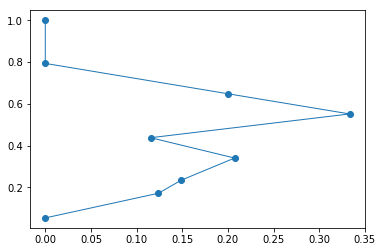

In [30]:
feature_set = [] # feature set of all trigramas ending with a noun
for doc in enumerate(spacy_docs):
    token_list = normalize_text(doc[1][1]) # normalize the text
    feature_set.append(
        (
            doc[1][0],
            generate_ngram(token_list, 3, ending_noun=True)
        )
    )
    
# get the 1000 most common trigrams
trigram_frequencies = Counter()
case_names = []
for case in feature_set:
    for trigram in case[1]:
        case_names.append(get_case_name_from_filename(case[0]))
        trigram_frequencies.update({trigram:1})
most_common = trigram_frequencies.most_common()[:1000]
features = pd.DataFrame(columns=[ngram[0] for ngram in most_common])
    
# create a feature set with the 1000 most common trigrams for every case
for case in feature_set:
    row = { x[0]:0 for x in most_common}
    for trigram in case[1]:
        if trigram in row.keys():
            row[trigram] += 1
    standardized_features = np.asarray(list(row.values()), dtype="float64")
    row = { most_common[x[0]][0]:x[1] for x in enumerate(standardized_features)}
    features = features.append(row, ignore_index=True)

# Standardize the features to variance 1
scaler = StandardScaler(copy=False, with_mean=False, with_std=True)
features = scaler.fit_transform(features)
# now every row in the feature set corresponds to one case file
del case_names # free memory
del feature_set # free memory
del standardized_features # free memory
del most_common
cases_reversed_dict = get_reversed_dict("case_reversed.csv")
Y = np.asarray(list(cases_reversed_dict.values())[:NUMBER_OF_CASES])
X, Y = shuffle(features, Y, random_state=314)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
Y_pred = cross_val_predict(log_reg, X_test, Y_test, method="decision_function", cv=10)
confusion_matrix_log_reg = confusion_matrix(Y_pred > 0.5, Y_test)
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
print("Precision: {0} Recall: {1} Thresholds: {2}".format(precision, recall, thresholds))
print("FPR: {0} TPR: {1} Thresholds: {2}".format(fpr, tpr, thresholds))
Y_pred = log_reg.predict_proba(X_test)
Y_score = log_reg.decision_function(X_test)
Y_prob = (Y_score - Y_score.min()) / (Y_score.max() - Y_score.min())

## Calibration Plot

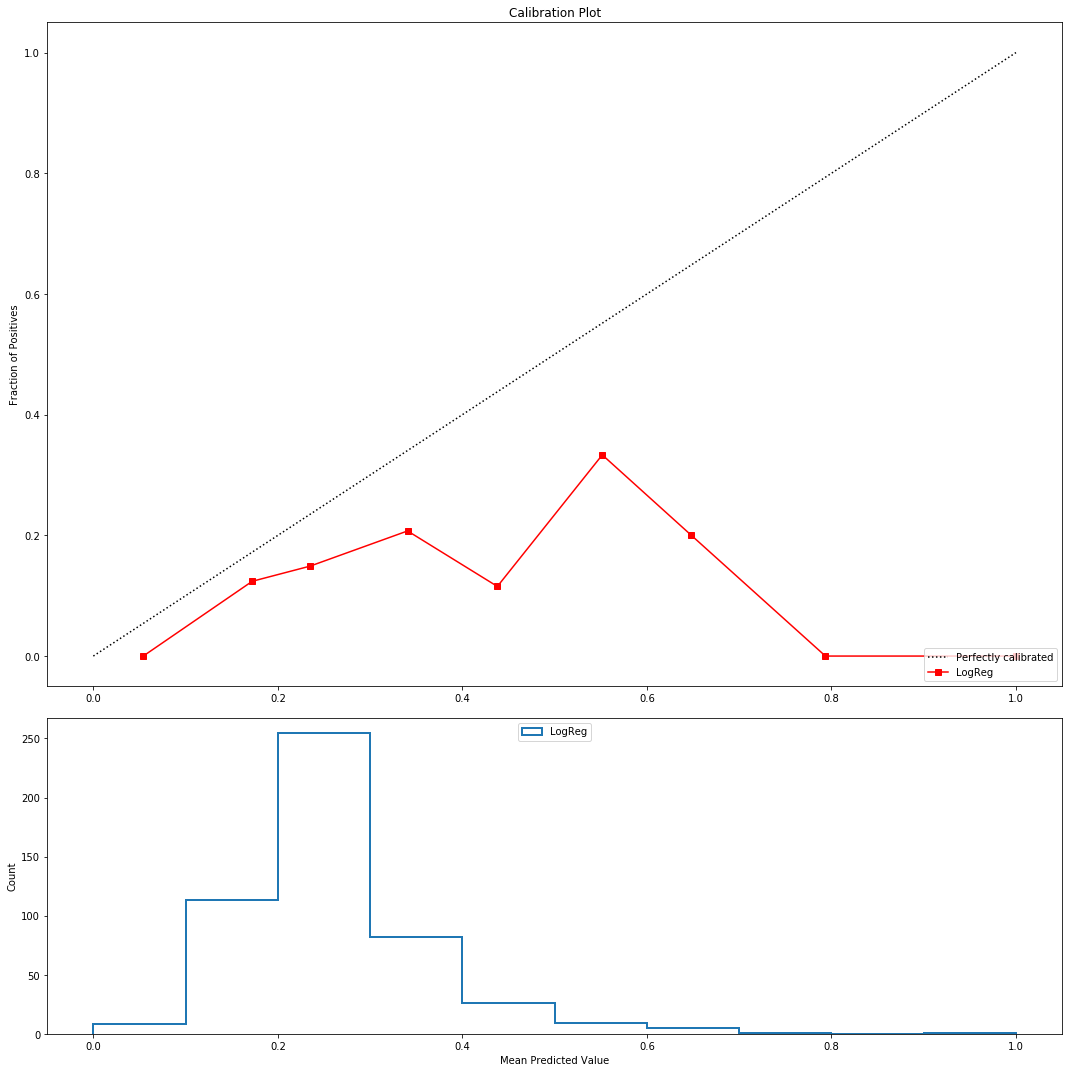

In [39]:
pyplot.figure(figsize=(15, 15))
ax1 = pyplot.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = pyplot.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
positives, mean = calibration_curve(Y_test, Y_prob, n_bins=10)
ax1.plot(mean, positives, "s-", color='r', label="%s" % ('LogReg', ))
ax2.hist(Y_prob, range=(0, 1), bins=10, label='LogReg', histtype="step", lw=2)
# name axes
ax1.set_ylabel("Fraction of Positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration Plot')
ax2.set_xlabel("Mean Predicted Value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
pyplot.tight_layout()
pyplot.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array 
  alpha: float
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `matplotlib.transforms.Bbox`
  clip_on: bool
  clip_path: { (`.path.Path`, `.transforms.Transform`), `.patches.Patch`, None } 
  color: color
  contains: callable
  figure: `.Figure`
  fontfamily: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties: `.font_manager.FontProperties`
  fontsize: {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle: {'normal', 'italic', 'oblique'}
  fontvariant: {'n

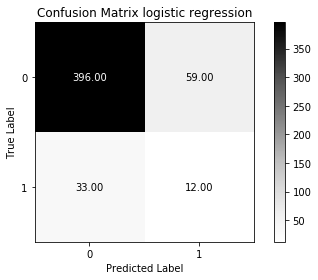

In [29]:
plot_confusion_matrix(confusion_matrix_log_reg, "Confusion Matrix logistic regression")

## Solution for Task 2

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   45.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  5.3min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  6.6min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  8.5min
[Parallel(n_jobs=8)]: Done 1500 out of 1500 | elapsed:  9.4min finished
C:\Users\test\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\test\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  Convergence

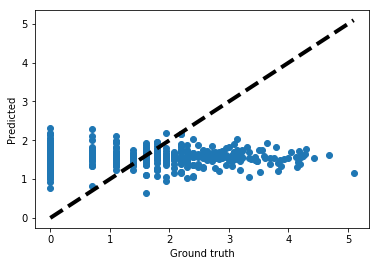

In [41]:
metadata = pd.read_csv("case_metadata.csv")
# replace NaN values with 0
metadata["log_cites"].fillna(0, inplace=True)
X, Y = shuffle(features, metadata["log_cites"][:NUMBER_OF_CASES], random_state=314)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
parameter_grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 5.0, 7.0, 10.0],
    "l1_ratio": np.arange(0.0, 1.0, 0.1),
}
elastic_net = ElasticNet(max_iter=2000)
grid_search = GridSearchCV(
    estimator=elastic_net,              
    param_grid=parameter_grid,          
    scoring="neg_mean_squared_error",   
    n_jobs=8,                       
    iid=True,                          
    cv=10,
    refit=True,
    verbose=1,
    return_train_score=True,
)
grid_search.fit(X_train, Y_train)
elastic_net_best = grid_search.best_estimator_
predicted = cross_val_predict(elastic_net_best, X_test, Y_test, cv=10)
fig, ax = pyplot.subplots()
ax.scatter(Y_test, predicted)
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
ax.set_xlabel("Ground truth")
ax.set_ylabel("Predicted")
pyplot.show()

## Solution for Task 3

In [52]:
metadata = pd.read_csv("case_metadata.csv")
metadata["log_cites"].fillna(0, inplace=True)
metadata.head()
metadata["cites"] = np.exp(metadata["log_cites"])
metadata["avg_cites_judge"] = metadata.groupby(["judge_id"])["log_cites"].mean()
keep = pd.notnull(metadata["judge_id"]) & \
        pd.notnull(metadata["log_cites"]) & \
        pd.notnull(metadata["case_reversed"]) & \
        pd.notnull(metadata["avg_cites_judge"]) & \
        np.isfinite(metadata["judge_id"]) & \
        np.isfinite(metadata["log_cites"]) & \
        np.isfinite(metadata["case_reversed"])
metadata = metadata[keep]
formula = "case_reversed ~ 1 + C(year) + [cites ~ avg_cites_judge]"
fs = IV2SLS.from_formula(formula, data=metadata)
results_fs = fs.fit()

formula_ols = "case_reversed ~ 1 + C(year) + cites"
predictor_ols = IV2SLS.from_formula(formula_ols, data=metadata)
results_ols = predictor_ols.fit()

In [53]:
results_fs

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:          case_reversed   R-squared:                     -5.8628
Estimator:                    IV-2SLS   Adj. R-squared:                -7.0465
No. Observations:                 606   F-statistic:                    57.545
Date:                Wed, Apr 17 2019   P-value (F-stat)                0.9961
Time:                        22:22:16   Distribution:                 chi2(89)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             0.0016     0.6170     0.0025     0.9980     -1.2077      1.2108
C(year)[T.1926.0]     0.1040     0.2901     0.3586     0.7199     -0.4645      0.6725
C(year)[T.1927.0]     0.3326     0.5017     0.6629     0.5074     -0.6508      1.3159
C(year)[T.1928.0]     0.5115     0.3563     1.4355     0.1512     -0.1869      1.2099
C(year)[T.1929.0]     0.5100     0.4113     1.2399     0.2150     -0.2962      1.3162
C(year)[T.1930.0]     0.3346     0.2806     1.1927     0.2330     -0.2153      0.8845
C(year)[T.1931.0]     0.1142     0.3312     0.3448     0.7302     -0.5349      0.7633
C(year)[T.1932.0]     0.0698     0.2721     0.2563     0.7977     -0.4636      0.6031
C(year)[T.1933.0]    -0.1360     0.3381    -0.4022     0.6875     -0.7986      0.5267
C(year)[T.1934.0]    -0.2752     0.2249    -1.2239     0.2210     -0.7159      0.1655
C(year)[T.1935.0]    -0.3386     0.3139    -1.0785     0.2808     -0.9539      0.2767
C(year)[T.1936.0]    -0.2224     0.2239    -0.9933     0.3206     -0.6612      0.2165
C(year)[T.1937.0]    -0.1474     0.3177    -0.4639     0.6428     -0.7701      0.4754
C(year)[T.1938.0]    -0.3515     0.3296    -1.0665     0.2862     -0.9976      0.2945
C(year)[T.1939.0]    -0.4275     0.4886    -0.8749     0.3816     -1.3850      0.5301
C(year)[T.1940.0]    -0.2554     0.2268    -1.1259     0.2602     -0.7000      0.1892
C(year)[T.1941.0]    -0.1485     0.3174    -0.4678     0.6399     -0.7705      0.4735
C(year)[T.1942.0]    -0.5776     0.8399    -0.6878     0.4916     -2.2237      1.0684
C(year)[T.1943.0]    -0.7361     1.1943    -0.6163     0.5377     -3.0768      1.6046
C(year)[T.1944.0]    -0.5694     0.8340    -0.6828     0.4947     -2.2039      1.0651
C(year)[T.1945.0]    -0.6929     1.2011    -0.5769     0.5640     -3.0470      1.6612
C(year)[T.1946.0]    -0.2284     0.2153    -1.0607     0.2888     -0.6504      0.1936
C(year)[T.1947.0]    -0.4028     0.4429    -0.9093     0.3632     -1.2709      0.4654
C(year)[T.1948.0]    -0.3256     0.2968    -1.0972     0.2726     -0.9073      0.2560
C(year)[T.1949.0]    -0.6389     0.9544    -0.6694     0.5032     -2.5094      1.2317
C(year)[T.1950.0]    -0.4606     0.5486    -0.8397     0.4011     -1.5358      0.6146
C(year)[T.1951.0]    -0.2917     0.2405    -1.2130     0.2251     -0.7629      0.1796
C(year)[T.1952.0]    -0.1559     0.3031    -0.5143     0.6070     -0.7499      0.4382
C(year)[T.1953.0]    -1.0039     1.8131    -0.5537     0.5798     -4.5576      2.5497
C(year)[T.1954.0]    -0.5805     0.8521    -0.6813     0.4957     -2.2506      1.0895
C(year)[T.1955.0]    -0.3781     0.3753    -1.0073     0.3138     -1.1137      0.3576
C(year)[T.1956.0]    -0.2423     0.2125    -1.1400     0.2543     -0.6588      0.1743
C(year)[T.1957.0]    -0.2896     0.2347    -1.2337     0.2173     -0.7497      0.1705
C(year)[T.1958.0]    -0.3213     0.2792    -1.1507     0.2498     -0.8685      0.2259
C(year)[T.1959.0]    -0.2608     0.2317    -1.1

In [54]:
results_ols

OLS Estimation Summary                            
==============================================================================
Dep. Variable:          case_reversed   R-squared:                      0.5068
Estimator:                        OLS   Adj. R-squared:                 0.4217
No. Observations:                 606   F-statistic:                    111.64
Date:                Wed, Apr 17 2019   P-value (F-stat)                0.0526
Time:                        22:22:16   Distribution:                 chi2(89)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             0.2537     0.1528     1.6600     0.0969     -0.0458      0.5532
C(year)[T.1926.0]     0.0492     0.2105     0.2337     0.8152     -0.3634      0.4618
C(year)[T.1927.0]     0.5025     0.2154     2.3333     0.0196      0.0804      0.9246
C(year)[T.1928.0]     0.4153     0.2189     1.8969     0.0578     -0.0138      0.8443
C(year)[T.1929.0]     0.3730     0.2294     1.6260     0.1040     -0.0766      0.8226
C(year)[T.1930.0]     0.3658     0.2034     1.7982     0.0721     -0.0329      0.7646
C(year)[T.1931.0]     0.1252     0.2288     0.5469     0.5844     -0.3234      0.5737
C(year)[T.1932.0]     0.1004     0.1860     0.5399     0.5893     -0.2642      0.4651
C(year)[T.1933.0]    -0.2517     0.1527    -1.6478     0.0994     -0.5510      0.0477
C(year)[T.1934.0]    -0.2496     0.1527    -1.6351     0.1020     -0.5488      0.0496
C(year)[T.1935.0]    -0.2487     0.1526    -1.6293     0.1033     -0.5479      0.0505
C(year)[T.1936.0]    -0.2504     0.1527    -1.6399     0.1010     -0.5497      0.0489
C(year)[T.1937.0]    -0.2515     0.1527    -1.6468     0.0996     -0.5509      0.0478
C(year)[T.1938.0]    -0.2485     0.1526    -1.6281     0.1035     -0.5476      0.0507
C(year)[T.1939.0]    -0.2474     0.1526    -1.6211     0.1050     -0.5465      0.0517
C(year)[T.1940.0]    -0.2499     0.1527    -1.6369     0.1017     -0.5492      0.0493
C(year)[T.1941.0]    -0.2515     0.1527    -1.6467     0.0996     -0.5508      0.0478
C(year)[T.1942.0]    -0.2452     0.1526    -1.6071     0.1080     -0.5442      0.0538
C(year)[T.1943.0]    -0.2428     0.1525    -1.5923     0.1113     -0.5417      0.0561
C(year)[T.1944.0]    -0.2453     0.1526    -1.6074     0.1080     -0.5443      0.0538
C(year)[T.1945.0]    -0.2435     0.1526    -1.5954     0.1106     -0.5425      0.0556
C(year)[T.1946.0]    -0.2503     0.1527    -1.6394     0.1011     -0.5496      0.0489
C(year)[T.1947.0]    -0.2477     0.1526    -1.6233     0.1045     -0.5469      0.0514
C(year)[T.1948.0]    -0.2489     0.1526    -1.6304     0.1030     -0.5481      0.0503
C(year)[T.1949.0]    -0.2443     0.1525    -1.6015     0.1093     -0.5432      0.0547
C(year)[T.1950.0]    -0.2469     0.1526    -1.6181     0.1056     -0.5459      0.0522
C(year)[T.1951.0]    -0.2494     0.1527    -1.6336     0.1023     -0.5486      0.0498
C(year)[T.1952.0]    -0.2514     0.1527    -1.6460     0.0998     -0.5507      0.0479
C(year)[T.1953.0]    -0.2389     0.1524    -1.5670     0.1171     -0.5376      0.0599
C(year)[T.1954.0]    -0.2451     0.1525    -1.6069     0.1081     -0.5441      0.0539
C(year)[T.1955.0]    -0.2481     0.1526    -1.6257     0.1040     -0.5472      0.0510
C(year)[T.1956.0]    -0.2501     0.1527    -1.6381     0.1014     -0.5494      0.0491
C(year)[T.1957.0]    -0.2494     0.1527    -1.6338     0.1023     -0.5486      0.0498
C(year)[T.1958.0]    -0.2489     0.1526    -1.6309     0.1029     -0.5481      0.0502
C(year)[T.1959.0]    -0.2498     0.1527    -1.636

## Solution for Task 4

I tested values raning from 1 to 20 topics. With too many topics it seems like there are a lot of overlaping words in different topic plots. So I decided to use less topics. 5 topics looks like a reasonable amount of topics.
With less then 3 topics it is pretty hard to find a common topic for all words in a word cloud.

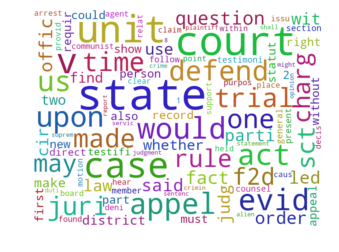

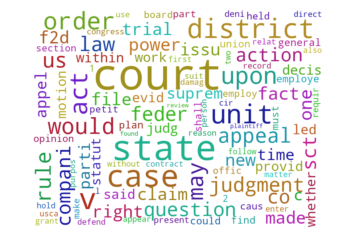

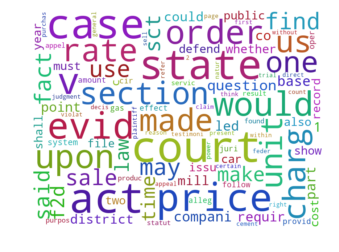

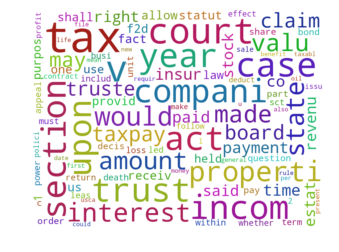

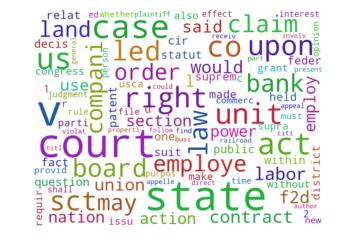

In [8]:
docs_clean = [clean_document(doc[1].text) for doc in spacy_docs]
random.shuffle(docs_clean)
dictionary = corpora.Dictionary(docs_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in docs_clean]
lda = LdaModel(doc_term_matrix, num_topics=5, id2word = dictionary, passes=3)
for i,weights in lda.show_topics(num_topics=-1, num_words=100, formatted=False):
    wordcloud = WordCloud(background_color="white", 
                          ranks_only=False, 
                          max_font_size=120,
                          color_func=color_func,
                          height=600,width=800).generate_from_frequencies(dict(weights))

    pyplot.clf()
    pyplot.imshow(wordcloud,interpolation="bilinear")
    pyplot.axis("off")
    pyplot.show()

## Solution for Task 5

It is pretty hard to compare the performance of the different models because all of them work pretty bad.
When having a look at the AUC we can conclude that all of them are working not much better than simple guessing.
This could maybe be improved when we use the whole dataset (I used 2500 cases) for training. It would maybe also help to increase the number of features used. I only use 1000 features to train the model for performance reasons.

In [9]:
cases_reversed_dict = get_reversed_dict("case_reversed.csv")
Y = np.asarray(list(cases_reversed_dict.values())[:NUMBER_OF_CASES])
X, Y = shuffle(features, Y, random_state=314)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
Y_pred_log_reg = cross_val_predict(log_reg, X_test, Y_test, method="decision_function", cv=10)
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(Y_test, Y_pred_log_reg)
auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], activation="relu", kernel_initializer="he_normal", kernel_regularizer=l2(0.01), activity_regularizer=l2(0.01))) # fully connected input layer
model.add(Dense(2, activation="softmax")) # fully connected output layer
model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # use adam instead of sgd (should be faster)
model_info = model.fit(X_train, onehot_encoding(Y_train),  epochs=1000, validation_split=.2, verbose=0)
Y_pred_keras = model.predict(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, Y_pred_keras.argmax(axis=1))
auc_keras = auc(fpr_keras, tpr_keras)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                20020     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 42        
Total params: 20,062
Trainable params: 20,062
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


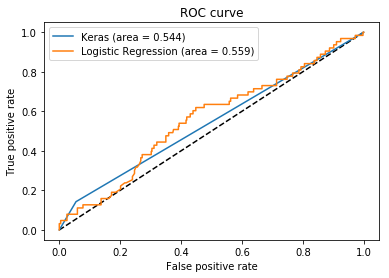

In [10]:
pyplot.figure(1)
pyplot.plot([0, 1], [0, 1], "k--")
pyplot.plot(fpr_keras, tpr_keras, label="Keras (area = {:.3f})".format(auc_keras))
pyplot.plot(fpr_log_reg, tpr_log_reg, label="Logistic Regression (area = {:.3f})".format(auc_log_reg))
pyplot.xlabel("False positive rate")
pyplot.ylabel("True positive rate")
pyplot.title("ROC curve")
pyplot.legend(loc="best")
pyplot.show()

 ### Model with Hidden-Layers and Dropout

In [15]:
model = Sequential()
model.add(Dense(int(X_train.shape[1]*.75), input_dim=X_train.shape[1], activation="relu", kernel_initializer="he_normal", kernel_regularizer=l2(0.01), activity_regularizer=l2(0.01))) # fully connected input layer
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(int(X_train.shape[1]*.5), activation="relu", kernel_initializer="he_normal", kernel_regularizer=l2(0.01), activity_regularizer=l2(0.01))) # hidden layer 1
model.add(BatchNormalization())
model.add(Dense(int(X_train.shape[1]*.25), activation="relu", kernel_initializer="he_normal", kernel_regularizer=l2(0.01), activity_regularizer=l2(0.01))) # hidden layer 2
model.add(BatchNormalization())
model.add(Dense(2, activation="softmax")) # fully connected output layer
model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # use adam instead of sgd (should be faster)
model_info = model.fit(X_train, onehot_encoding(Y_train),  epochs=200, validation_split=.2, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 750)               750750    
_________________________________________________________________
batch_normalization_7 (Batch (None, 750)               3000      
_________________________________________________________________
dropout_3 (Dropout)          (None, 750)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 500)               375500    
_________________________________________________________________
batch_normalization_8 (Batch (None, 500)               2000      
_________________________________________________________________
dense_13 (Dense)             (None, 250)               125250    
_________________________________________________________________
batch_normalization_9 (Batch (None, 250)               1000      
__________

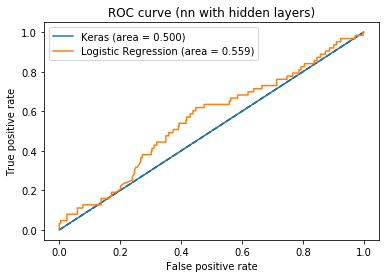

In [16]:
Y_pred_keras = model.predict(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, Y_pred_keras.argmax(axis=1))
auc_keras = auc(fpr_keras, tpr_keras)
pyplot.figure(1)
pyplot.plot([0, 1], [0, 1], "k--")
pyplot.plot(fpr_keras, tpr_keras, label="Keras (area = {:.3f})".format(auc_keras))
pyplot.plot(fpr_log_reg, tpr_log_reg, label="Logistic Regression (area = {:.3f})".format(auc_log_reg))
pyplot.xlabel("False positive rate")
pyplot.ylabel("True positive rate")
pyplot.title("ROC curve (nn with hidden layers)")
pyplot.legend(loc="best")
pyplot.show()